<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/%EC%96%91%EC%9E%90%EC%BB%B4%EC%88%98%ED%96%89%EB%B0%A9%EB%B2%95_aer_ibm_ionq_qpu_NewQiskit_20240308.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
######################################################
# 코드의 목적: Quantum Computer접속 및 Job 제출방법(기본), Qiskit Version Up으로 제작성 및 최적화
# 작성자: 박문기(mkbahk@gmail.com)
# 최초작성일: 20230926
######################################################

In [48]:
!python3 -m pip install qiskit[visualization]
!python3 -m pip install qiskit-ionq
!python3 -m pip install qiskit-ibm-provider
!python3 -m pip install qiskit-aer

In [28]:
# 참조: https://github.com/Qiskit/qiskit-ibm-provider/blob/main/docs/tutorials/1_the_ibm_quantum_account.ipynb
# IBMQ Cloud 서비스 사용하기 위한 준비
from qiskit_ibm_provider import IBMProvider

# IBM  Provider에 등록된 계정 정보를 입력합니다.
IBMProvider.save_account(token='7fa75760795ced2265d7692ff98c883ce10ebdc4ccb18f484c994c23e31659c4347ec23d39a3a481b52f8a8b1dfb092f83fd068de92a727aae504f3661b2e4f7',overwrite=True)

# IBM Provider로 접속합니다.
ibm_provider = IBMProvider()

# 양자회로를 수행한 양자컴퓨터 백엔드 리스트 출력
#print(ibm_provider.backends())
print("Available backends:")

for backend in ibm_provider.backends():
  print(backend.name)
###for

Available backends:
ibmq_qasm_simulator
simulator_extended_stabilizer
simulator_mps
simulator_statevector
simulator_stabilizer
ibm_brisbane
ibm_kyoto
ibm_osaka


In [29]:
# IonQ H/W Cloud를 사용하기 위한 준비
from qiskit_ionq import IonQProvider

# IonQ Cloud 서비스 사용하기 위한 준비
ionq_provider = IonQProvider("xOgBTOQhnQ3Gsx4SKGJkUPeWwC2dPMKg") #IonQ Cloud에서 Access Key를 복사해 넣어야 합니다.

# 백엔드 리스트 출력
print("Available backends:")

for backend in ionq_provider.backends():
  print(backend.name())
###for

Available backends:
ionq_simulator
ionq_qpu


In [30]:
# Qiskit Local Simulator 사용하기 위한 준비
from qiskit_aer import Aer

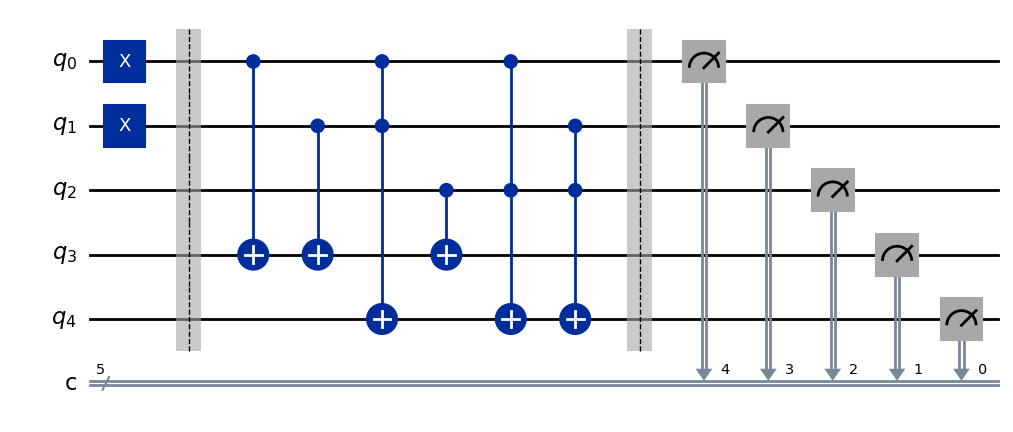

In [62]:
from qiskit import QuantumCircuit

# 양자 회로 생성
qc = QuantumCircuit(5, 5)  # 5개의 양자 비트와 2개의 클래식 비트를 사용합니다.

# 입력 비트 설정 (A=1, B=1)
qc.x(0)  # A 비트를 1로 설정
qc.x(1)  # B 비트를 1로 설정
qc.barrier()

# 반-가산기 회로 구현
qc.cx(0, 3) # XOR 게이트 (A와 B의 논리합)
qc.cx(1, 3) # XOR 게이트 (A와 B의 논리합)
qc.ccx(0, 1, 4) # AND 게이트 (A와 B의 논리곱)
qc.cx(2, 3) # XOR 게이트 (A와 B의 논리합)
qc.ccx(0, 2, 4) # AND 게이트 (A와 B의 논리곱)
qc.ccx(1, 2, 4) # AND 게이트 (A와 B의 논리곱)
qc.barrier()

# 결과를 측정하여 Sum과 Carry 출력을 얻습니다.
qc.measure(0, 4)  # 큐비트를 클래식 비트 4에 매핑
qc.measure(1, 3)  # 큐비트를 클래식 비트 3에 매핑
qc.measure(2, 2)  # 보조비트를 클래식 비트 2에 매핑
qc.measure(3, 1)  # Sum(Result) 비트를 클래식 비트 1에 매핑
qc.measure(4, 0)  # Carry 비트를 클래식 비트 0에 매핑

qc.draw('mpl')

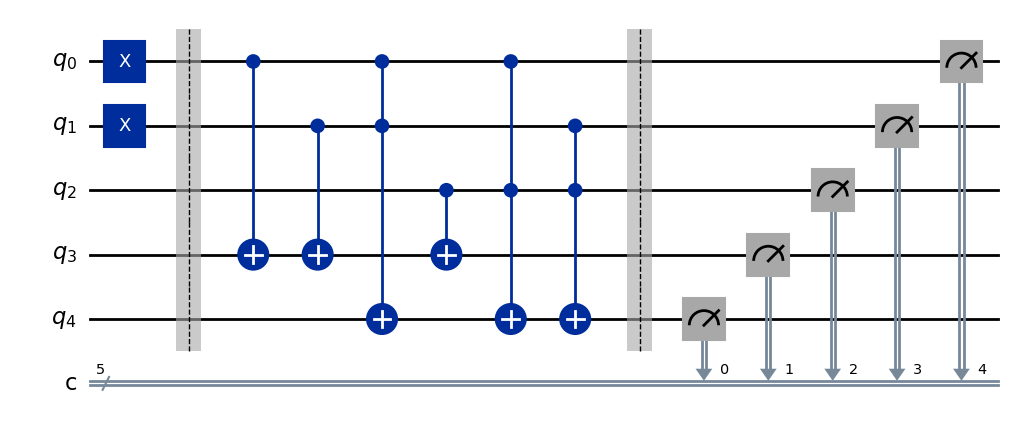

In [63]:
#여러 장치들에게 선택적으로 수행시키기 위한 준비
from qiskit.compiler import transpile, assemble
#
#백엔드들을 이용한 실제 장치나 시뮬레이터를 이용한 실행
#
#backend = ionq_provider.get_backend('ionq_simulator')
#backend = ionq_provider.get_backend('ionq_qpu')
backend = ibm_provider.get_backend('ibmq_qasm_simulator') # Cloud상 시뮬레이터
#backend = ibm_provider.get_backend('ibmq_quito')
#backend = Aer.get_backend('qasm_simulator')  #Local Qiskit Aer 시뮬레이터 사용

#양자컴 하드웨어마다 지원할 수 있는 Gate의 종류가 달라서, 일반GATE를 각 하드웨어 지원 Gate로 변환하는 과정을 Transpile이라 한다.
trans_qc = transpile(qc, backend)
trans_qc.draw('mpl')

In [64]:
from qiskit.providers.jobstatus import JobStatus
import time

job = backend.run(trans_qc, shots=1024)
#job = backend.run(qc, shots=2048) # if you don’t pass a shots kwarg, it defaults to 1024

print("Job ID is", job.job_id(),"\n")

# 제출된 잡에 대한 실행 상태 확인
while job.status() is not JobStatus.DONE:
	print("Job status is", job.status() )
	time.sleep(2)
###while

# grab a coffee! This can take up to a few minutes.
# once we break out of that while loop, we know our job is finished
print("Job status is", job.status() )

# 결과 출력
counts = job.result().get_counts()
print(counts)

Job ID is cnl9itgalmrcvvn5rvr0 

Job status is JobStatus.DONE
Job status is JobStatus.DONE
{'11001': 1024}


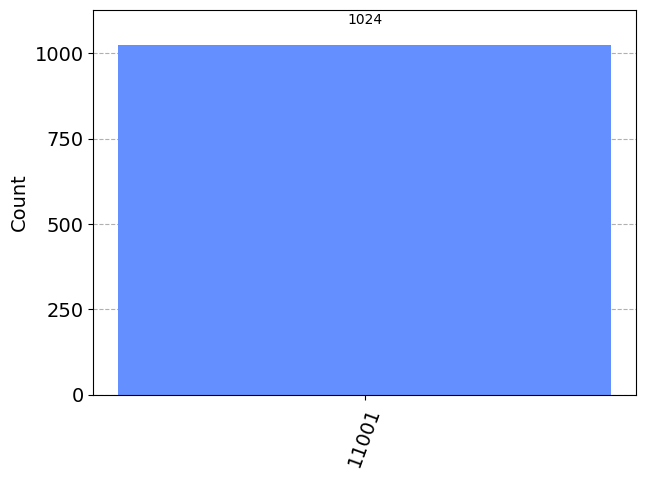

In [65]:
from qiskit.visualization import plot_histogram
plot_histogram(data=counts)

In [66]:
import qiskit.utils
qiskit.utils.local_hardware_info()

{'python_compiler': 'GCC 11.4.0',
 'python_build': 'main, Nov 20 2023 15:14:05',
 'python_version': '3.10.12',
 'os': 'Linux',
 'cpus': 1}